### Introdução

Nesse trabalho, usando autoencoder LSTM, será feito um codificação e decodificação de dados de eletrocardiogramas a partir de dados de série temporal usando um autoencoder LSTM. O objetivo é gerar um espaço lantente onde tenha informações com baixa dimensionalidade para ser usado no treinamento de outros modelos.

### Dados

O conjunto de dados contém 5.000 exemplos de séries temporais (obtidos com ECG) com 140 intervalos de tempo. Cada sequência corresponde a um único batimento cardíaco de um único paciente com insuficiência cardíaca congestiva.

Um eletrocardiograma (ECG ou EKG) é um teste que verifica como o coração está funcionando, medindo a atividade elétrica do coração. A cada batimento cardíaco, um impulso elétrico (ou onda) viaja pelo seu coração. Essa onda faz com que o músculo se contraia e bombeie o sangue do coração. Fonte

Temos 5 tipos de batimentos cardíacos (classes):

- > Normais (N)
- > Contração Ventricular Prematura R-on-T (R-on-T PVC)
- > Contração Ventricular Prematura (PVC)
- > Batimento supraventricular prematuro ou ectópico (SP ou EB)
- >Batida não classificada (UB).

Supondo um coração saudável e uma frequência típica de 70 a 75 batimentos por minuto, cada ciclo cardíaco, ou batimento cardíaco, leva cerca de 0,8 segundos para completar o ciclo. Frequência: 60–100 por minuto (Humanos) Duração: 0,6–1 segundo (Humanos)

In [12]:
import torch
import torch.nn as nn
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import copy 


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:

with open('data/ECG5000_TRAIN.arff') as f:
    train, meta = arff.loadarff(f)
  
with open('data/ECG5000_TEST.arff') as f:
    test, meta = arff.loadarff(f)

FileNotFoundError: [Errno 2] No such file or directory: 'data/ECG5000_TRAIN.arff'

In [4]:
# Converter 'train'  e 'test' em um DataFrame
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)
print(train_df.shape)
print(test_df.shape)


(500, 141)
(4500, 141)


b'1'


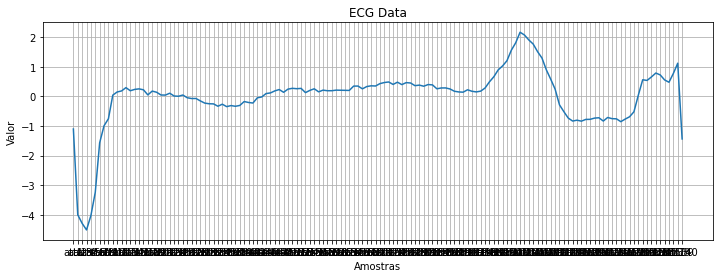

In [51]:
# Escolhendo o índice para plotar (por exemplo, o primeiro ECG, índice 0)
linha = 1
ecg_data = train_df.iloc[linha, : -1]
print(train_df.iloc[linha,140])

plt.figure(figsize = (12,4))
plt.plot(ecg_data)
plt.title("ECG Data")
plt.xlabel("Amostras")
plt.ylabel("Valor")
plt.grid(True)

In [52]:
# Juntando e embaralhando os dataframes

# Juntar e embaralhar os DataFrames
df = pd.concat([train_df, test_df], ignore_index=True)  # Junta os DataFrames
df = df.sample(frac=1.0).reset_index(drop=True)  # Embaralha e reseta o índice
print(df.shape)

(5000, 141)


Temos 5.000 exemplos. Cada linha representa um único registro de pulsação. Vamos nomear as classes possíveis:

In [53]:
nomes_classes= ['Normal','R em T','PVC','SP','UB']

In [54]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [55]:
df.target.value_counts()

target
b'1'    2919
b'2'    1767
b'4'     194
b'3'      96
b'5'      24
Name: count, dtype: int64

### Codificador automático LSTM

A tarefa do Autoencoder é obter alguns dados de entrada, passá-los pelo modelo e obter uma reconstrução da entrada. A reconstrução deve corresponder tanto quanto possível à entrada. O truque é usar um pequeno número de parâmetros, para que seu modelo aprenda uma representação compactada dos dados.

De certa forma, os Autoencoders tentam aprender apenas os recursos mais importantes (versão compactada) dos dados. Aqui, veremos como alimentar dados de série temporal para um Autoencoder. Usaremos algumas camadas LSTM (daí o Autoencoder LSTM) para capturar as dependências temporais dos dados.

#### Perda de construção
Ao treinar um Autoencoder, o objetivo é reconstruir a entrada da melhor maneira possível. Isso é feito minimizando uma função de perda (assim como no aprendizado supervisionado). Esta função é conhecida como perda de reconstrução . Perda de entropia cruzada e erro quadrático médio são exemplos comuns.

### Pré-processamento

In [56]:
from sklearn.model_selection import train_test_split

# Remover a última coluna (coluna da classe)
df = df.iloc[:, :-1]

# Reduza o tamanho do DataFrame para 1/4 do tamanho original de forma aleatória
df = df.sample(frac=0.25, random_state=42)

# Dividir o DataFrame em treinamento (70%) e temp (30%)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

# Dividir o temp_df em validação (50%) e teste (50%)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Exibir as formas dos conjuntos resultantes
print("Conjunto de Treinamento:", train_df.shape)
print("Conjunto de Validação:", valid_df.shape)
print("Conjunto de Teste:", test_df.shape)


Conjunto de Treinamento: (875, 140)
Conjunto de Validação: (187, 140)
Conjunto de Teste: (188, 140)


Precisamos converter nossos exemplos em tensores, para que possamos usá-los para treinar nosso Autoencoder. Vamos escrever uma função auxiliar para isso:

In [57]:

def create_dataset(df):
    # Converte o DataFrame em uma lista de sequências de números de ponto flutuante
    sequences = df.astype(np.float32).to_numpy().tolist()
    
    # Converte as sequências em tensores do PyTorch e ajusta as dimensões
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    
    # Obtém o número de sequências, comprimento da sequência e número de recursos
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    
    # Retorna o dataset, comprimento da sequência e número de recursos
    return dataset, seq_len, n_features


In [58]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(valid_df)
test_normal_dataset, _, _ = create_dataset(test_df)


In [59]:
print(len(train_dataset))
print(seq_len)
print(n_features)

print(len(val_dataset))
print(len(test_normal_dataset))

875
140
1
187
188


Cada série temporal será convertida em um tensor 2D no comprimento da sequência de formas x número de recursos (140x1 no nosso caso).

### LSTM Autoencoder


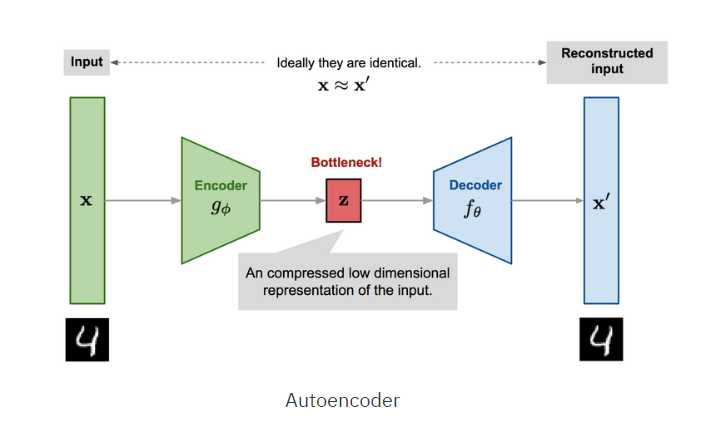

In [42]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        # Inicializa a classe do codificador, que é uma subclasse de nn.Module
        super(Encoder, self).__init__()
    
        # Define os atributos da classe com os argumentos de entrada
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    
        # Define duas camadas de redes neurais recorrentes (LSTM) no construtor
        self.rnn1 = nn.LSTM(
            input_size=n_features,         # Tamanho da entrada
            hidden_size=self.hidden_dim,   # Tamanho da camada oculta
            num_layers=1,                  # Número de camadas
            batch_first=True               # Batch_first define a dimensão do lote
        )
        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,     # Tamanho de entrada, usando a camada oculta anterior como entrada
            hidden_size=embedding_dim,      # Tamanho da camada oculta
            num_layers=1,                   # Número de camadas
            batch_first=True                # Batch_first define a dimensão do lote
        )
    
    def forward(self, x):
        # Define a passagem para a frente do modelo
        x = x.reshape((1, self.seq_len, self.n_features))  # Remodela a entrada
        x, (_, _) = self.rnn1(x)                           # Passa pela primeira camada LSTM
        x, (hidden_n, _) = self.rnn2(x)                    # Passa pela segunda camada LSTM
        return hidden_n.reshape((self.n_features, self.embedding_dim))  # Retorna a saída remapeada


O codificador usa duas camadas LSTM para compactar a entrada de dados da série temporal. A seguir, decodificaremos a representação compactada usando um Decoder :

In [43]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        # Inicializa a classe do decodificador, que é uma subclasse de nn.Module
        super(Decoder, self).__init__()
        
        # Define os atributos da classe com os argumentos de entrada
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features
        
        # Define duas camadas de redes neurais recorrentes (LSTM) no construtor
        self.rnn1 = nn.LSTM(
            input_size=input_dim,           # Tamanho da entrada
            hidden_size=input_dim,          # Tamanho da camada oculta
            num_layers=1,                  # Número de camadas
            batch_first=True               # Batch_first define a dimensão do lote
        )
        self.rnn2 = nn.LSTM(
            input_size=input_dim,           # Tamanho de entrada
            hidden_size=self.hidden_dim,   # Tamanho da camada oculta
            num_layers=1,                  # Número de camadas
            batch_first=True               # Batch_first define a dimensão do lote
        )
        self.output_layer = nn.Linear(self.hidden_dim, n_features)
        
    def forward(self, x):
        # Define a passagem para a frente do modelo
        x = x.repeat(self.seq_len, self.n_features)        # Repete a entrada
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))  # Remodela a entrada
        x, (hidden_n, cell_n) = self.rnn1(x)               # Passa pela primeira camada LSTM
        x, (hidden_n, cell_n) = self.rnn2(x)               # Passa pela segunda camada LSTM
        x = x.reshape((self.seq_len, self.hidden_dim))     # Remodela a saída
        return self.output_layer(x)                        # Retorna a saída da camada de saída


Nosso decodificador contém duas camadas LSTM e uma camada de saída que fornece a reconstrução final. É hora de agrupar tudo em um módulo fácil de usar:

In [44]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

O Autoencoder passa a entrada através do codificador e do decodificador. Vamos criar uma instância disso:

In [45]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

### Treinamento

In [168]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    # Inicializa o otimizador Adam para atualizar os parâmetros do modelo
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # Define a função de perda como a perda L1
    criterion = nn.L1Loss(reduction='sum').to(device)
    
    # Inicializa um dicionário para rastrear o histórico de perdas de treinamento e validação
    history = dict(train=[], val=[])
    
    # Inicializa os melhores pesos do modelo e a melhor perda
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    
    # Loop de treinamento para o número especificado de épocas
    for epoch in tqdm(range(1, n_epochs + 1)):
       
        # Define o modelo no modo de treinamento
        model = model.train()
        
        # Inicializa uma lista para rastrear as perdas de treinamento
        train_losses = []
        
        print("treinamento para cada sequência no conjunto...")
        # Loop de treinamento para cada sequência no conjunto de treinamento
        for index, seq_true in enumerate(train_dataset):
            optimizer.zero_grad()
            seq_true = seq_true.to(device)
            
            # Passa a sequência verdadeira através do modelo para obter a sequência prevista
            seq_pred = model(seq_true)
            
            # Calcula a perda entre a sequência prevista e a verdadeira
            loss = criterion(seq_pred, seq_true)
            
            # Realiza a retropropagação e atualização dos pesos do modelo
            loss.backward()
            optimizer.step()
            
            # Adiciona a perda atual à lista de perdas de treinamento
            train_losses.append(loss.item())
        
        # Inicializa uma lista para rastrear as perdas de validação
        val_losses = []
    

        
        # Define o modelo no modo de avaliação (sem cálculo de gradientes)
        model = model.eval()
        
        print("loop de validação para cada sequencia...")
        # Loop de validação para cada sequência no conjunto de validação
        with torch.no_grad():
            for seq_true in val_dataset:
                seq_true = seq_true.to(device)
                
                # Passa a sequência verdadeira através do modelo para obter a sequência prevista
                seq_pred = model(seq_true)
                
                # Calcula a perda entre a sequência prevista e a verdadeira
                loss = criterion(seq_pred, seq_true)
                
                # Adiciona a perda atual à lista de perdas de validação
                val_losses.append(loss.item())
        
        # Calcula a perda média de treinamento e validação para esta época
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        
        # Adiciona as perdas médias ao histórico
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        
        # Verifica se a perda de validação atual é a melhor até agora
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        
        # Imprime as perdas de treinamento e validação para esta época
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
    
    # Carrega os melhores pesos do modelo
    model.load_state_dict(best_model_wts)
    # Retorna o modelo no modo de avaliação e o histórico de perdas
    return model.eval(), history


A cada época, o processo de treinamento alimenta nosso modelo com todos os exemplos de treinamento e avalia o desempenho no conjunto de validação. Observe que estamos usando um tamanho de lote 1 (nosso modelo vê apenas 1 sequência por vez). Também registramos as perdas do conjunto de treinamento e validação durante o processo.

Observe que estamos minimizando o L1Loss , que mede o MAE (erro médio absoluto). Por que? As reconstruções parecem ser melhores do que com MSE (erro quadrático médio).

Obteremos a versão do modelo com o menor erro de validação. Vamos fazer um treinamento:

In [169]:
model, history = train_model(
    model,
    train_dataset,
    val_dataset,
    n_epochs=150
)


  0%|                                                                                          | 0/150 [00:00<?, ?it/s]

treinamento para cada sequência no conjunto...
loop de validação para cada sequencia...
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c


  1%|▌                                                                               | 1/150 [01:10<2:55:46, 70.78s/it]


c
c
c
c
c
Epoch 1: train loss 79.01190512520927 val loss 81.95735092979064
treinamento para cada sequência no conjunto...
loop de validação para cada sequencia...
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c


  1%|█                                                                               | 2/150 [02:22<2:55:41, 71.22s/it]


c
c
c
c
c
Epoch 2: train loss 65.03380144827706 val loss 61.746152296423276
treinamento para cada sequência no conjunto...
loop de validação para cada sequencia...
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c


  2%|█▌                                                                              | 3/150 [03:35<2:56:26, 72.01s/it]


c
c
c
Epoch 3: train loss 62.1810428074428 val loss 59.00785456366717
treinamento para cada sequência no conjunto...
loop de validação para cada sequencia...
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c


  3%|██▏                                                                             | 4/150 [04:51<2:59:13, 73.66s/it]


c
c
Epoch 4: train loss 59.10524701799665 val loss 56.7717929166906
treinamento para cada sequência no conjunto...
loop de validação para cada sequencia...
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c


  3%|██▋                                                                             | 5/150 [06:06<2:58:50, 74.00s/it]


c
c
c
c
c
c
Epoch 5: train loss 57.59190878949847 val loss 65.7442594314004
treinamento para cada sequência no conjunto...
loop de validação para cada sequencia...
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c


  4%|███▏                                                                            | 6/150 [07:20<2:57:52, 74.11s/it]


c
c
c
c
c
c
Epoch 6: train loss 62.98081723022461 val loss 58.43730473645868
treinamento para cada sequência no conjunto...
loop de validação para cada sequencia...
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c


  5%|███▋                                                                            | 7/150 [08:34<2:56:50, 74.20s/it]


c
c
c
c
c
c
c
Epoch 7: train loss 57.569470328194754 val loss 54.685987503133354
treinamento para cada sequência no conjunto...
loop de validação para cada sequencia...
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c


  5%|████▎                                                                           | 8/150 [09:52<2:58:01, 75.22s/it]


c
c
c
Epoch 8: train loss 55.72191613115583 val loss 57.40745974862002
treinamento para cada sequência no conjunto...
loop de validação para cada sequencia...
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c


  6%|████▊                                                                           | 9/150 [11:09<2:58:18, 75.87s/it]


c
c
c
Epoch 9: train loss 54.782097185407366 val loss 50.71349324517072
treinamento para cada sequência no conjunto...
loop de validação para cada sequencia...
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c


  7%|█████▎                                                                         | 10/150 [12:36<3:05:13, 79.38s/it]


c
c
c
c
c
Epoch 10: train loss 51.72709486171178 val loss 49.10927092200294
treinamento para cada sequência no conjunto...
loop de validação para cada sequencia...
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c


  7%|█████▊                                                                         | 11/150 [14:15<3:17:29, 85.24s/it]


c
c
Epoch 11: train loss 49.462668635777064 val loss 48.39183062793099
treinamento para cada sequência no conjunto...


  7%|█████▊                                                                         | 11/150 [14:27<3:02:42, 78.86s/it]


KeyboardInterrupt: 

### Salvando o modelo

In [ ]:
MODEL_PATH = 'model.pth'
torch.save(model, MODEL_PATH)

In [ ]:
# Remova o comentário das próximas linhas, se desejar baixar e carregar o modelo pré-treinado:
# !gdown --id 1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
# model = torch.load('model.pth')
# model = model.to(device)

### Previsões

Com nosso modelo em mãos, podemos dar uma olhada no erro de reconstrução no conjunto de treinamento. Vamos começar escrevendo uma função auxiliar para obter previsões do nosso modelo:

In [171]:
def predict(model, dataset):
    # Inicialize listas vazias para armazenar previsões e perdas
    predictions, losses = [], []

    # Defina a função de perda (L1Loss) com redução de soma e mova para o dispositivo
    criterion = nn.L1Loss(reduction='sum').to(device)

    # Desative o cálculo de gradientes e defina o modelo no modo de avaliação
    with torch.no_grad():
        model = model.eval()

        # Itere sobre cada sequência verdadeira no conjunto de dados
        for seq_true in dataset:
            seq_true = seq_true.to(device)  # Mova a sequência verdadeira para o dispositivo
            seq_pred = model(seq_true)      # Faça previsões com o modelo
            loss = criterion(seq_pred, seq_true)  # Calcule a perda entre as previsões e a sequência verdadeira

            # Armazene as previsões como um array NumPy achatado
            predictions.append(seq_pred.cpu().numpy().flatten())

            # Armazene o valor da perda
            losses.append(loss.item())

    # Retorne as previsões e as perdas
    return predictions, losses


Nossa função analisa cada exemplo do conjunto de dados e registra as previsões e perdas. Vamos pegar as perdas e dar uma olhada nelas:



In [172]:
_, losses = predict(model, train_dataset)
sns.distplot(losses, bins=50, kde=True);

NameError: name 'sns' is not defined

In [ ]:
THRESHOLD = 26


### Evaluation

Usando o limite, podemos transformar o problema em uma tarefa simples de classificação binária:

Se a perda de reconstrução, por exemplo, estiver abaixo do limite, classificaremos como batimento cardíaco normal
Alternativamente, se a perda for superior ao limite, classificaremos como uma anomalia

In [ ]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [ ]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')